# 11.3c: Initial State Geometry Analysis

**Question:** What is the geometric structure of ALL tokens at initialization (t=0)?

## Hypothesis

Qwen's initialization method is:
```python
base_vector + Gaussian(0, σ=ε)
```

After bfloat16 quantization, this creates a tight cluster where many tokens share the same quantized vector (initial black holes).

Dead tokens have **no gradients** during training, so they stay exactly where they started. The 4 final black holes didn't drift apart—they were *born* in those positions.

## Analysis Plan

1. Load initial embeddings (step 0) from 11.2c
2. Compute pairwise L∞ distances for ALL 128 tokens
3. Check how many tokens are touching (L∞ ≤ 2ε)
4. Analyze the initial black hole structure
5. Compare dead vs alive token initial positions

## Parameters

In [1]:
# Data from 11.2c
EMBEDDING_PATH = "../data/embeddings_128vocab_primordial_snowball/embedding_evolution.safetensors"

# Corpus to identify dead tokens
CORPUS_PATH = "../data/training_corpus.txt"
VOCAB_SIZE = 128

# Expected noise scale from 11.2c
EPSILON = 3e-5

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from collections import Counter

## Load Initial Embeddings

In [3]:
print(f"Loading embedding history from {EMBEDDING_PATH}...\n")

data = load_file(EMBEDDING_PATH)
embedding_history = data['embedding_history']  # [steps, vocab, dim]

num_steps, vocab_size, hidden_dim = embedding_history.shape

# Extract INITIAL state (step 0)
initial_embeddings = embedding_history[0].to(torch.float32)

print(f"✓ Loaded initial embeddings (t=0)")
print(f"  Vocabulary: {vocab_size}")
print(f"  Hidden dim: {hidden_dim}")

Loading embedding history from ../data/embeddings_128vocab_primordial_snowball/embedding_evolution.safetensors...

✓ Loaded initial embeddings (t=0)
  Vocabulary: 128
  Hidden dim: 64


## Identify Dead vs Alive Tokens

In [4]:
print(f"\nIdentifying dead vs alive tokens...\n")

# Load corpus and find which tokens appear
with open(CORPUS_PATH, 'r', encoding='ascii') as f:
    corpus_text = f.read()

corpus_bytes = [b for b in corpus_text.encode('ascii') if b < VOCAB_SIZE]
alive_tokens = sorted(set(corpus_bytes))
dead_tokens = sorted([t for t in range(VOCAB_SIZE) if t not in alive_tokens])

print(f"✓ Tokens classified")
print(f"  Alive: {len(alive_tokens)}")
print(f"  Dead: {len(dead_tokens)}")


Identifying dead vs alive tokens...

✓ Tokens classified
  Alive: 77
  Dead: 51


## Initial Black Hole Analysis

In [5]:
print(f"\nAnalyzing initial black holes...\n")

# Find unique vectors
unique_vectors, inverse_indices, counts = torch.unique(
    initial_embeddings,
    dim=0,
    return_inverse=True,
    return_counts=True
)

# Black holes (count ≥ 2)
black_hole_mask = counts >= 2
n_black_holes = black_hole_mask.sum().item()
black_hole_population = counts[black_hole_mask].sum().item()
n_singletons = len(unique_vectors) - n_black_holes

print(f"✓ Initial state structure:")
print(f"  Unique vectors: {len(unique_vectors)}")
print(f"  Black holes (count ≥ 2): {n_black_holes}")
print(f"  Black hole population: {black_hole_population}")
print(f"  Singletons: {n_singletons}")
print(f"\nLargest black holes:")
sorted_counts = sorted(counts[black_hole_mask].tolist(), reverse=True)
for i, count in enumerate(sorted_counts[:10], 1):
    print(f"  #{i}: {count} tokens")
if len(sorted_counts) > 10:
    print(f"  ... ({len(sorted_counts) - 10} more)")


Analyzing initial black holes...

✓ Initial state structure:
  Unique vectors: 85
  Black holes (count ≥ 2): 29
  Black hole population: 72
  Singletons: 56

Largest black holes:
  #1: 5 tokens
  #2: 4 tokens
  #3: 4 tokens
  #4: 4 tokens
  #5: 4 tokens
  #6: 3 tokens
  #7: 3 tokens
  #8: 3 tokens
  #9: 2 tokens
  #10: 2 tokens
  ... (19 more)


## Compute Pairwise L∞ Distances (All 128 Tokens)

In [6]:
print(f"\nComputing pairwise L∞ distances for all {vocab_size} tokens...\n")

# Compute pairwise differences
v1 = initial_embeddings.unsqueeze(1)  # [128, 1, 64]
v2 = initial_embeddings.unsqueeze(0)  # [1, 128, 64]
diffs = v1 - v2  # [128, 128, 64]

# L∞ distance = max absolute component difference
l_inf_distances = torch.abs(diffs).max(dim=2)[0]  # [128, 128]

# Mask out diagonal (self-distances)
mask = ~torch.eye(vocab_size, dtype=torch.bool)
l_inf_nondiag = l_inf_distances[mask]

print(f"✓ Computed {vocab_size * (vocab_size - 1) // 2:,} pairwise distances")
print(f"\nSummary statistics (L∞):")
print(f"  Min: {l_inf_nondiag.min().item():.6e}")
print(f"  Max: {l_inf_nondiag.max().item():.6e}")
print(f"  Mean: {l_inf_nondiag.mean().item():.6e}")
print(f"  Median: {l_inf_nondiag.median().item():.6e}")
print(f"\nRatio to ε:")
print(f"  Min / ε: {l_inf_nondiag.min().item() / EPSILON:.2f}×")
print(f"  Max / ε: {l_inf_nondiag.max().item() / EPSILON:.2f}×")
print(f"  Mean / ε: {l_inf_nondiag.mean().item() / EPSILON:.2f}×")


Computing pairwise L∞ distances for all 128 tokens...

✓ Computed 8,128 pairwise distances

Summary statistics (L∞):
  Min: 0.000000e+00
  Max: 4.882812e-04
  Mean: 2.541805e-04
  Median: 9.155273e-05

Ratio to ε:
  Min / ε: 0.00×
  Max / ε: 16.28×
  Mean / ε: 8.47×


## Touching Analysis

In [7]:
print(f"\n{'='*80}")
print(f"TOUCHING ANALYSIS")
print(f"{'='*80}")

# Count touching pairs (L∞ ≤ 2ε)
touching_threshold = 2 * EPSILON
touching_pairs = (l_inf_nondiag <= touching_threshold).sum().item()
total_pairs = len(l_inf_nondiag)
pct_touching = 100 * touching_pairs / total_pairs

print(f"Touching threshold: 2ε = {touching_threshold:.2e}")
print(f"\nTouching pairs: {touching_pairs:,} / {total_pairs:,} ({pct_touching:.1f}%)")

# Distribution of distances
bins = [0, 2*EPSILON, 5*EPSILON, 10*EPSILON, 20*EPSILON, float('inf')]
labels = ['≤2ε (touching)', '2-5ε', '5-10ε', '10-20ε', '>20ε']

print(f"\nDistance distribution:")
for i in range(len(bins)-1):
    count = ((l_inf_nondiag > bins[i]) & (l_inf_nondiag <= bins[i+1])).sum().item()
    pct = 100 * count / total_pairs
    print(f"  {labels[i]:15s}: {count:6,} ({pct:5.1f}%)")

print(f"{'='*80}")


TOUCHING ANALYSIS
Touching threshold: 2ε = 6.00e-05

Touching pairs: 2,190 / 16,256 (13.5%)

Distance distribution:
  ≤2ε (touching) :  2,062 ( 12.7%)
  2-5ε           :  6,676 ( 41.1%)
  5-10ε          :     80 (  0.5%)
  10-20ε         :  7,310 ( 45.0%)
  >20ε           :      0 (  0.0%)


## Dead vs Alive Token Analysis

In [8]:
print(f"\n{'='*80}")
print(f"DEAD vs ALIVE TOKEN GEOMETRY")
print(f"{'='*80}")

# Extract dead and alive embeddings
dead_embeddings = initial_embeddings[dead_tokens]
alive_embeddings = initial_embeddings[alive_tokens]

# Dead-dead distances
v1_dead = dead_embeddings.unsqueeze(1)
v2_dead = dead_embeddings.unsqueeze(0)
diffs_dead = v1_dead - v2_dead
l_inf_dead = torch.abs(diffs_dead).max(dim=2)[0]
mask_dead = ~torch.eye(len(dead_tokens), dtype=torch.bool)
l_inf_dead_nondiag = l_inf_dead[mask_dead]

# Alive-alive distances
v1_alive = alive_embeddings.unsqueeze(1)
v2_alive = alive_embeddings.unsqueeze(0)
diffs_alive = v1_alive - v2_alive
l_inf_alive = torch.abs(diffs_alive).max(dim=2)[0]
mask_alive = ~torch.eye(len(alive_tokens), dtype=torch.bool)
l_inf_alive_nondiag = l_inf_alive[mask_alive]

print(f"Dead-Dead distances (tokens that never get trained):")
print(f"  Min: {l_inf_dead_nondiag.min().item():.6e} ({l_inf_dead_nondiag.min().item()/EPSILON:.2f}× ε)")
print(f"  Max: {l_inf_dead_nondiag.max().item():.6e} ({l_inf_dead_nondiag.max().item()/EPSILON:.2f}× ε)")
print(f"  Mean: {l_inf_dead_nondiag.mean().item():.6e} ({l_inf_dead_nondiag.mean().item()/EPSILON:.2f}× ε)")
touching_dead = (l_inf_dead_nondiag <= 2*EPSILON).sum().item()
total_dead_pairs = len(l_inf_dead_nondiag)
print(f"  Touching pairs: {touching_dead:,} / {total_dead_pairs:,} ({100*touching_dead/total_dead_pairs:.1f}%)")

print(f"\nAlive-Alive distances (tokens that get gradient updates):")
print(f"  Min: {l_inf_alive_nondiag.min().item():.6e} ({l_inf_alive_nondiag.min().item()/EPSILON:.2f}× ε)")
print(f"  Max: {l_inf_alive_nondiag.max().item():.6e} ({l_inf_alive_nondiag.max().item()/EPSILON:.2f}× ε)")
print(f"  Mean: {l_inf_alive_nondiag.mean().item():.6e} ({l_inf_alive_nondiag.mean().item()/EPSILON:.2f}× ε)")
touching_alive = (l_inf_alive_nondiag <= 2*EPSILON).sum().item()
total_alive_pairs = len(l_inf_alive_nondiag)
print(f"  Touching pairs: {touching_alive:,} / {total_alive_pairs:,} ({100*touching_alive/total_alive_pairs:.1f}%)")

print(f"{'='*80}")


DEAD vs ALIVE TOKEN GEOMETRY
Dead-Dead distances (tokens that never get trained):
  Min: 0.000000e+00 (0.00× ε)
  Max: 4.882812e-04 (16.28× ε)
  Mean: 2.545405e-04 (8.48× ε)
  Touching pairs: 342 / 2,550 (13.4%)

Alive-Alive distances (tokens that get gradient updates):
  Min: 0.000000e+00 (0.00× ε)
  Max: 4.882812e-04 (16.28× ε)
  Mean: 2.565573e-04 (8.55× ε)
  Touching pairs: 744 / 5,852 (12.7%)


## Histogram: Distance Distribution

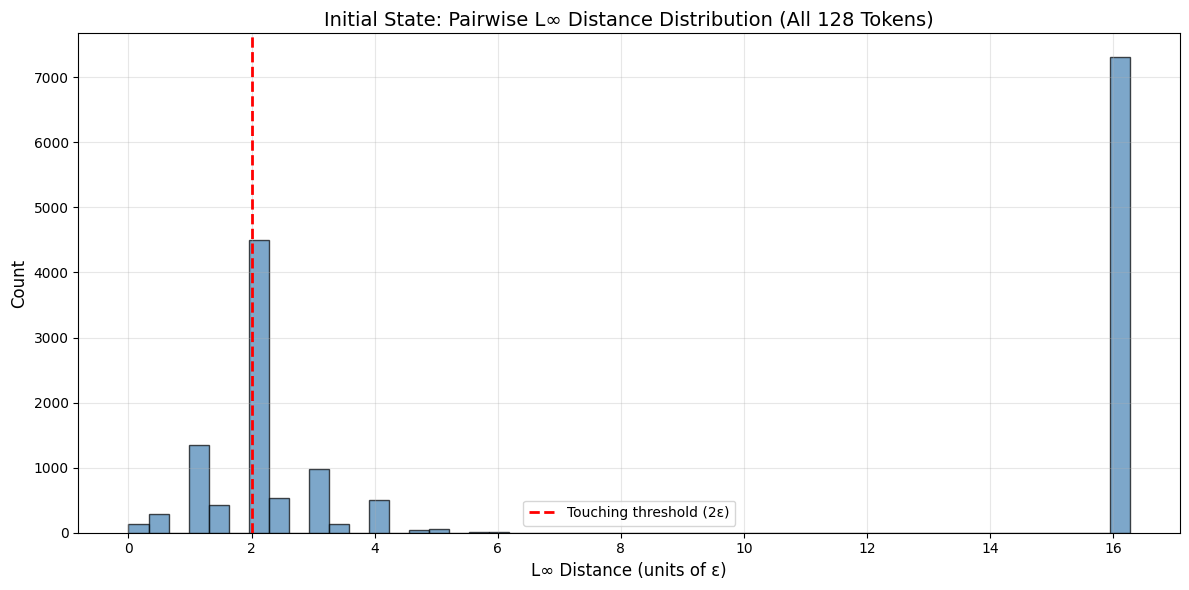

In [9]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

# Convert to units of ε for plotting
distances_in_epsilon = (l_inf_nondiag / EPSILON).numpy()

# Histogram
counts, bins, patches = ax.hist(distances_in_epsilon, bins=50, color='steelblue', edgecolor='black', alpha=0.7)

# Mark touching threshold
ax.axvline(2, color='red', linestyle='--', linewidth=2, label='Touching threshold (2ε)')

ax.set_xlabel("L∞ Distance (units of ε)", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Initial State: Pairwise L∞ Distance Distribution (All 128 Tokens)", fontsize=14)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

In [10]:
print(f"\n{'='*80}")
print(f"SUMMARY: INITIAL STATE GEOMETRY (t=0)")
print(f"{'='*80}")
print(f"Total tokens: {vocab_size}")
print(f"  Alive: {len(alive_tokens)}")
print(f"  Dead: {len(dead_tokens)}")
print(f"\nInitial structure:")
print(f"  Unique vectors: {len(unique_vectors)}")
print(f"  Black holes: {n_black_holes}")
print(f"  Black hole population: {black_hole_population}")
print(f"  Singletons: {n_singletons}")
print(f"\nPairwise distances (all tokens):")
print(f"  Range: [{l_inf_nondiag.min().item():.2e}, {l_inf_nondiag.max().item():.2e}]")
print(f"  Mean: {l_inf_nondiag.mean().item():.2e} ({l_inf_nondiag.mean().item()/EPSILON:.1f}× ε)")
print(f"  Touching pairs: {touching_pairs:,}/{total_pairs:,} ({pct_touching:.1f}%)")
print(f"\nDead token cluster:")
print(f"  Max L∞: {l_inf_dead_nondiag.max().item():.2e} ({l_inf_dead_nondiag.max().item()/EPSILON:.1f}× ε)")
print(f"  Touching: {100*touching_dead/total_dead_pairs:.1f}% of pairs")
print(f"\nConclusion:")
if pct_touching > 50:
    print(f"  ✓ Majority of tokens touching at initialization")
    print(f"  → Gaussian + bfloat16 quantization creates tight cluster")
else:
    print(f"  ⚠ Most tokens NOT touching at initialization")
    print(f"  → Initial noise σ may be too large for tight snowball")

if touching_dead/total_dead_pairs > 0.5:
    print(f"  ✓ Dead tokens form connected cluster")
    print(f"  → These positions are FROZEN during training (no gradients)")
else:
    print(f"  ⚠ Dead tokens scattered at initialization")
    print(f"  → Final black holes inherit this scattered structure")
    
print(f"{'='*80}")


SUMMARY: INITIAL STATE GEOMETRY (t=0)
Total tokens: 128
  Alive: 77
  Dead: 51

Initial structure:
  Unique vectors: 85
  Black holes: 29
  Black hole population: 72
  Singletons: 56

Pairwise distances (all tokens):
  Range: [0.00e+00, 4.88e-04]
  Mean: 2.54e-04 (8.5× ε)
  Touching pairs: 2,190/16,256 (13.5%)

Dead token cluster:
  Max L∞: 4.88e-04 (16.3× ε)
  Touching: 13.4% of pairs

Conclusion:
  ⚠ Most tokens NOT touching at initialization
  → Initial noise σ may be too large for tight snowball
  ⚠ Dead tokens scattered at initialization
  → Final black holes inherit this scattered structure
